In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored

from sksurv.nonparametric import kaplan_meier_estimator

In [45]:
df_neuro = pd.read_csv("../Training_neurodegenerative.csv")

In [46]:
diagnoses_path = "/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/UKBB_diagnoses_Jun2025/processed/diagnoses_extracted"

df = pd.read_csv("../Training_healthycontrol.csv")

In [47]:
df_hc = df[df["Diagnosis"] == 0]
df_neuro = df_neuro[df_neuro["Diagnosis"] == 0]

In [48]:
df_dates_neuro = pd.read_csv("../Neurodegenerative_training_date_diagnosis.csv")

In [49]:
df_dates_neuro.rename(columns={"diff_years":"time_to_diagnosis"},inplace=True)

In [50]:
df_neuro = pd.merge(df_neuro,df_dates_neuro[["time_to_diagnosis","eid"]], on="eid")

In [51]:
df_neuro["Diagnosis"] =1

In [52]:
df = pd.concat([df_hc,df_neuro])

In [53]:
#Read columns that should be imputed (the rest are missing in more than 30% of PD participants)
protein_cols = np.loadtxt("../columns_30pd.txt", dtype=str).tolist()
all_protein_cols = np.loadtxt("../all_proteins.txt", dtype=str).tolist()
columns_drop = set(all_protein_cols) - set(protein_cols)
df = df.drop(columns=columns_drop)

In [54]:
df["Diagnosis"].value_counts()

0    21128
1      996
Name: Diagnosis, dtype: int64

In [55]:
demo = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/demographics_processed.csv")
visit_dates = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/Visit_dates.csv")

In [56]:
covariates = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/proteomics/Processed_all_covariates.csv").iloc[:,1:]

In [57]:
covariates_test_cols=["Age", "Sex", "Ethnicity", "smoking", "alcohol", "Season" , "fasting_time", "sample_age"]

In [58]:
df

,eid,AARSD1,ABHD14B,ABL1,ACAA1,ACAN,ACE2,ACOX1,ACP5,ACP6,...,XCL1,XG,XPNPEP2,XRCC4,YES1,YTHDF3,ZBTB16,ZBTB17,Diagnosis,time_to_diagnosis
0,1000266,0.40715,-0.11755,0.25745,-0.14200,-0.3076,-0.50160,-0.36515,-0.35605,0.17345,...,-0.7023,0.52995,1.53505,0.11865,-0.5861,-1.22825,0.25620,0.06445,0,NaN
1,1000497,0.42255,0.01375,-0.02095,0.77410,0.4052,1.18680,0.41475,-0.21105,0.05995,...,0.0777,-0.20725,-0.09645,-0.45255,-0.6894,0.01585,0.15010,0.11465,0,NaN
2,1000677,-0.31630,-0.38540,0.00970,-0.23070,0.4422,-0.39305,-0.60440,-0.02200,-0.08620,...,0.9023,0.20170,-0.40520,-0.09675,-0.3827,0.15355,0.25355,0.09420,0,NaN
3,1000850,-0.55015,-0.25335,-0.31335,-0.84740,0.2507,-0.03310,-0.69155,-0.17635,0.17275,...,0.1791,-0.28295,-0.74595,-0.52915,0.1189,1.14845,-0.22110,0.19575,0,NaN
4,1001107,0.20225,-1.09045,-0.32760,0.64995,-0.1662,-0.18165,-0.11460,0.45770,0.52750,...,0.2106,0.04970,0.47620,-0.05590,-0.7313,-1.36320,-0.25515,0.37860,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,5995803,-0.46530,-0.85890,-0.14850,-1.48490,-0.0874,-0.32295,0.27960,0.19960,-0.39770,...,-0.2488,-0.36490,-2.19900,0.17535,-0.1039,-0.33875,-0.75605,-0.37590,1,-23.093771
992,6001141,0.37620,0.18190,0.34980,1.38300,-0.2919,0.64260,-0.00440,0.45610,-0.08100,...,-0.2028,-0.72800,0.53910,0.38985,0.1715,0.64120,-0.16475,-0.00840,1,13.396304
993,6001861,-0.30225,0.40650,0.56540,-0.35670,-0.2519,-0.67465,0.03810,-0.29500,-0.65210,...,0.4703,0.21750,-1.20240,-0.06635,0.7397,0.61945,0.62175,-0.33650,1,10.639288
994,6004084,-0.94390,-0.83600,-0.63920,3.19800,0.0124,-0.49310,-0.83750,-0.66960,-1.42590,...,-0.4659,0.04870,0.12170,NaN,-0.4756,-0.60810,-0.52320,-0.38090,1,5.533196


In [59]:
df_dates = pd.merge(df, visit_dates[["eid","p53_i0"]], on="eid")

In [60]:
import pandas as pd

# Make sure p53_i0 is datetime
df_dates["p53_i0"] = pd.to_datetime(df_dates["p53_i0"])

# Compute difference in years 
diff_years_fill = (pd.Timestamp("2024-09-30") - df_dates["p53_i0"]).dt.total_seconds() / (365.25*24*3600)

# Fill NaNs only hC
df_dates["time_to_diagnosis"] = df_dates["time_to_diagnosis"].fillna(diff_years_fill)


In [61]:
df_dates

,eid,AARSD1,ABHD14B,ABL1,ACAA1,ACAN,ACE2,ACOX1,ACP5,ACP6,...,XG,XPNPEP2,XRCC4,YES1,YTHDF3,ZBTB16,ZBTB17,Diagnosis,time_to_diagnosis,p53_i0
0,1000266,0.40715,-0.11755,0.25745,-0.14200,-0.3076,-0.50160,-0.36515,-0.35605,0.17345,...,0.52995,1.53505,0.11865,-0.5861,-1.22825,0.25620,0.06445,0,14.351814,2010-05-25
1,1000497,0.42255,0.01375,-0.02095,0.77410,0.4052,1.18680,0.41475,-0.21105,0.05995,...,-0.20725,-0.09645,-0.45255,-0.6894,0.01585,0.15010,0.11465,0,16.109514,2008-08-21
2,1000677,-0.31630,-0.38540,0.00970,-0.23070,0.4422,-0.39305,-0.60440,-0.02200,-0.08620,...,0.20170,-0.40520,-0.09675,-0.3827,0.15355,0.25355,0.09420,0,14.310746,2010-06-09
3,1000850,-0.55015,-0.25335,-0.31335,-0.84740,0.2507,-0.03310,-0.69155,-0.17635,0.17275,...,-0.28295,-0.74595,-0.52915,0.1189,1.14845,-0.22110,0.19575,0,16.306639,2008-06-10
4,1001107,0.20225,-1.09045,-0.32760,0.64995,-0.1662,-0.18165,-0.11460,0.45770,0.52750,...,0.04970,0.47620,-0.05590,-0.7313,-1.36320,-0.25515,0.37860,0,14.231348,2010-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22119,5995803,-0.46530,-0.85890,-0.14850,-1.48490,-0.0874,-0.32295,0.27960,0.19960,-0.39770,...,-0.36490,-2.19900,0.17535,-0.1039,-0.33875,-0.75605,-0.37590,1,-23.093771,2009-08-05
22120,6001141,0.37620,0.18190,0.34980,1.38300,-0.2919,0.64260,-0.00440,0.45610,-0.08100,...,-0.72800,0.53910,0.38985,0.1715,0.64120,-0.16475,-0.00840,1,13.396304,2009-05-26
22121,6001861,-0.30225,0.40650,0.56540,-0.35670,-0.2519,-0.67465,0.03810,-0.29500,-0.65210,...,0.21750,-1.20240,-0.06635,0.7397,0.61945,0.62175,-0.33650,1,10.639288,2009-09-04
22122,6004084,-0.94390,-0.83600,-0.63920,3.19800,0.0124,-0.49310,-0.83750,-0.66960,-1.42590,...,0.04870,0.12170,NaN,-0.4756,-0.60810,-0.52320,-0.38090,1,5.533196,2008-05-24


In [62]:

df_dates["time_to_diagnosis"] = df_dates["time_to_diagnosis"].round(2)


In [63]:
df_dates

,eid,AARSD1,ABHD14B,ABL1,ACAA1,ACAN,ACE2,ACOX1,ACP5,ACP6,...,XG,XPNPEP2,XRCC4,YES1,YTHDF3,ZBTB16,ZBTB17,Diagnosis,time_to_diagnosis,p53_i0
0,1000266,0.40715,-0.11755,0.25745,-0.14200,-0.3076,-0.50160,-0.36515,-0.35605,0.17345,...,0.52995,1.53505,0.11865,-0.5861,-1.22825,0.25620,0.06445,0,14.35,2010-05-25
1,1000497,0.42255,0.01375,-0.02095,0.77410,0.4052,1.18680,0.41475,-0.21105,0.05995,...,-0.20725,-0.09645,-0.45255,-0.6894,0.01585,0.15010,0.11465,0,16.11,2008-08-21
2,1000677,-0.31630,-0.38540,0.00970,-0.23070,0.4422,-0.39305,-0.60440,-0.02200,-0.08620,...,0.20170,-0.40520,-0.09675,-0.3827,0.15355,0.25355,0.09420,0,14.31,2010-06-09
3,1000850,-0.55015,-0.25335,-0.31335,-0.84740,0.2507,-0.03310,-0.69155,-0.17635,0.17275,...,-0.28295,-0.74595,-0.52915,0.1189,1.14845,-0.22110,0.19575,0,16.31,2008-06-10
4,1001107,0.20225,-1.09045,-0.32760,0.64995,-0.1662,-0.18165,-0.11460,0.45770,0.52750,...,0.04970,0.47620,-0.05590,-0.7313,-1.36320,-0.25515,0.37860,0,14.23,2010-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22119,5995803,-0.46530,-0.85890,-0.14850,-1.48490,-0.0874,-0.32295,0.27960,0.19960,-0.39770,...,-0.36490,-2.19900,0.17535,-0.1039,-0.33875,-0.75605,-0.37590,1,-23.09,2009-08-05
22120,6001141,0.37620,0.18190,0.34980,1.38300,-0.2919,0.64260,-0.00440,0.45610,-0.08100,...,-0.72800,0.53910,0.38985,0.1715,0.64120,-0.16475,-0.00840,1,13.40,2009-05-26
22121,6001861,-0.30225,0.40650,0.56540,-0.35670,-0.2519,-0.67465,0.03810,-0.29500,-0.65210,...,0.21750,-1.20240,-0.06635,0.7397,0.61945,0.62175,-0.33650,1,10.64,2009-09-04
22122,6004084,-0.94390,-0.83600,-0.63920,3.19800,0.0124,-0.49310,-0.83750,-0.66960,-1.42590,...,0.04870,0.12170,NaN,-0.4756,-0.60810,-0.52320,-0.38090,1,5.53,2008-05-24


In [74]:
subset_df = df_dates[~((df_dates["Diagnosis"] == 1) & (df_dates["time_to_diagnosis"] < 2))]


In [75]:
subset_df["Diagnosis"].value_counts()

0    21128
1      721
Name: Diagnosis, dtype: int64

In [76]:
subset_df = subset_df.drop(columns=["p53_i0"])

In [77]:
subset_df

,eid,AARSD1,ABHD14B,ABL1,ACAA1,ACAN,ACE2,ACOX1,ACP5,ACP6,...,XCL1,XG,XPNPEP2,XRCC4,YES1,YTHDF3,ZBTB16,ZBTB17,Diagnosis,time_to_diagnosis
0,1000266,0.40715,-0.11755,0.25745,-0.14200,-0.3076,-0.50160,-0.36515,-0.35605,0.17345,...,-0.7023,0.52995,1.53505,0.11865,-0.5861,-1.22825,0.25620,0.06445,0,14.35
1,1000497,0.42255,0.01375,-0.02095,0.77410,0.4052,1.18680,0.41475,-0.21105,0.05995,...,0.0777,-0.20725,-0.09645,-0.45255,-0.6894,0.01585,0.15010,0.11465,0,16.11
2,1000677,-0.31630,-0.38540,0.00970,-0.23070,0.4422,-0.39305,-0.60440,-0.02200,-0.08620,...,0.9023,0.20170,-0.40520,-0.09675,-0.3827,0.15355,0.25355,0.09420,0,14.31
3,1000850,-0.55015,-0.25335,-0.31335,-0.84740,0.2507,-0.03310,-0.69155,-0.17635,0.17275,...,0.1791,-0.28295,-0.74595,-0.52915,0.1189,1.14845,-0.22110,0.19575,0,16.31
4,1001107,0.20225,-1.09045,-0.32760,0.64995,-0.1662,-0.18165,-0.11460,0.45770,0.52750,...,0.2106,0.04970,0.47620,-0.05590,-0.7313,-1.36320,-0.25515,0.37860,0,14.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22118,5992797,-0.28495,-0.09990,1.65070,0.49960,0.0207,0.00455,0.05170,0.33070,0.90800,...,-0.7649,0.31990,1.47990,0.31855,1.7820,0.80165,1.03385,1.45530,1,12.97
22120,6001141,0.37620,0.18190,0.34980,1.38300,-0.2919,0.64260,-0.00440,0.45610,-0.08100,...,-0.2028,-0.72800,0.53910,0.38985,0.1715,0.64120,-0.16475,-0.00840,1,13.40
22121,6001861,-0.30225,0.40650,0.56540,-0.35670,-0.2519,-0.67465,0.03810,-0.29500,-0.65210,...,0.4703,0.21750,-1.20240,-0.06635,0.7397,0.61945,0.62175,-0.33650,1,10.64
22122,6004084,-0.94390,-0.83600,-0.63920,3.19800,0.0124,-0.49310,-0.83750,-0.66960,-1.42590,...,-0.4659,0.04870,0.12170,NaN,-0.4756,-0.60810,-0.52320,-0.38090,1,5.53


In [78]:
subset_df = pd.merge(
    subset_df,
    covariates[["eid"] + covariates_test_cols],
    on="eid",

)

In [79]:
subset_df["sample_age"]

0        4200.0
1        4842.0
2        4203.0
3        4913.0
4        4139.0
          ...  
21844    4834.0
21845    4645.0
21846    4552.0
21847    4907.0
21848    5307.0
Name: sample_age, Length: 21849, dtype: float64

In [80]:
# Example for covariates_test_cols
for col in covariates_test_cols:
    if subset_df[col].dtype == "object":
        subset_df[col] = subset_df[col].astype("category").cat.codes


In [81]:
subset_df

,eid,AARSD1,ABHD14B,ABL1,ACAA1,ACAN,ACE2,ACOX1,ACP5,ACP6,...,Diagnosis,time_to_diagnosis,Age,Sex,Ethnicity,smoking,alcohol,Season,fasting_time,sample_age
0,1000266,0.40715,-0.11755,0.25745,-0.14200,-0.3076,-0.50160,-0.36515,-0.35605,0.17345,...,0,14.35,56,0,4,2.0,6.0,1,4.0,4200.0
1,1000497,0.42255,0.01375,-0.02095,0.77410,0.4052,1.18680,0.41475,-0.21105,0.05995,...,0,16.11,58,1,4,0.0,1.0,0,4.0,4842.0
2,1000677,-0.31630,-0.38540,0.00970,-0.23070,0.4422,-0.39305,-0.60440,-0.02200,-0.08620,...,0,14.31,67,1,4,1.0,3.0,0,3.0,4203.0
3,1000850,-0.55015,-0.25335,-0.31335,-0.84740,0.2507,-0.03310,-0.69155,-0.17635,0.17275,...,0,16.31,58,1,4,0.0,3.0,0,16.0,4913.0
4,1001107,0.20225,-1.09045,-0.32760,0.64995,-0.1662,-0.18165,-0.11460,0.45770,0.52750,...,0,14.23,53,1,4,0.0,2.0,0,7.0,4139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21844,5992797,-0.28495,-0.09990,1.65070,0.49960,0.0207,0.00455,0.05170,0.33070,0.90800,...,1,12.97,58,0,4,1.0,4.0,1,2.0,4834.0
21845,6001141,0.37620,0.18190,0.34980,1.38300,-0.2919,0.64260,-0.00440,0.45610,-0.08100,...,1,13.40,56,1,4,1.0,4.0,1,3.0,4645.0
21846,6001861,-0.30225,0.40650,0.56540,-0.35670,-0.2519,-0.67465,0.03810,-0.29500,-0.65210,...,1,10.64,52,0,4,0.0,5.0,0,4.0,4552.0
21847,6004084,-0.94390,-0.83600,-0.63920,3.19800,0.0124,-0.49310,-0.83750,-0.66960,-1.42590,...,1,5.53,58,0,4,0.0,5.0,1,3.0,4907.0


In [82]:
subset_df = subset_df[~((subset_df["Diagnosis"] == 1) & (subset_df["time_to_diagnosis"] <= 2))]


In [83]:
import pandas as pd
from lifelines import CoxPHFitter

all_protein_summaries = []

for protein in protein_cols:
    cols = [protein] + covariates_test_cols + ["time_to_diagnosis", "Diagnosis"]
    df_model = subset_df[cols].dropna()
    
    cph = CoxPHFitter()
    cph.fit(df_model, duration_col="time_to_diagnosis", event_col="Diagnosis")
    
    # Extract only the protein row safely
    protein_row = cph.summary.loc[[protein]].copy()
    protein_row["Protein_tested"] = protein
    all_protein_summaries.append(protein_row)

# Concatenate all proteins into one DataFrame
protein_results_df = pd.concat(all_protein_summaries)

# Drop index (covariate names) to avoid duplicates
protein_results_df = protein_results_df.reset_index(drop=True)

# Keep only the useful columns
protein_results_df = protein_results_df[["Protein_tested", "coef", "exp(coef)", 
                                         "se(coef)", "coef lower 95%", "coef upper 95%", "p"]]

# Now sorting works safely
protein_results_df = protein_results_df.sort_values("p")

print(protein_results_df.head())

    Protein_tested      coef  exp(coef)  se(coef)  coef lower 95%  \
585           GFAP  0.822703   2.276645  0.039619        0.745050   
957           NEFL  0.765899   2.150928  0.052529        0.662944   
288         CHI3L1  0.269493   1.309300  0.038997        0.193060   
369           CST5 -0.404216   0.667500  0.063887       -0.529433   
582          GDF15  0.374973   1.454952  0.063002        0.251491   

     coef upper 95%             p  
585        0.900356  8.940393e-96  
957        0.868854  3.737529e-48  
288        0.345926  4.826568e-12  
369       -0.278999  2.499272e-10  
582        0.498455  2.653053e-09  


In [84]:
from statsmodels.stats.multitest import multipletests

# Make sure you have a p-value column
pvals = protein_results_df["p"].values  

# Apply FDR correction
reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")

# Add results back to dataframe
protein_results_df["p_fdr"] = pvals_corrected
protein_results_df["significant_fdr05"] = reject


In [85]:
protein_results_df[protein_results_df["significant_fdr05"] == True]["Protein_tested"].unique()

array(['GFAP', 'NEFL', 'CHI3L1', 'CST5', 'GDF15', 'BCAN', 'OMG',
       'TNFSF10', 'DCN', 'NPTXR', 'WNT9A', 'PVR', 'IL15', 'AREG',
       'EBI3_IL27', 'CLEC5A', 'TIMP4', 'IL13RA1', 'FURIN', 'CD276',
       'LAG3', 'BRK1', 'C1QA', 'B4GAT1', 'PI3', 'PSG1', 'ADAMTS8',
       'NELL2', 'MMP7', 'DPP4', 'EDA2R', 'DSG2', 'IL1RL1', 'TNC', 'PRL',
       'HPGDS', 'CD302', 'CA12', 'WFIKKN1', 'LGALS7_LGALS7B', 'EGFR',
       'NCS1', 'CDSN', 'ERBB2', 'IL10', 'TINAGL1', 'KDR', 'NTproBNP',
       'GZMH', 'PLAUR', 'LIFR', 'GZMA', 'PRELP', 'TNFSF11', 'LRRN1',
       'COL6A3', 'FGF5', 'ACE2', 'SPINK1'], dtype=object)

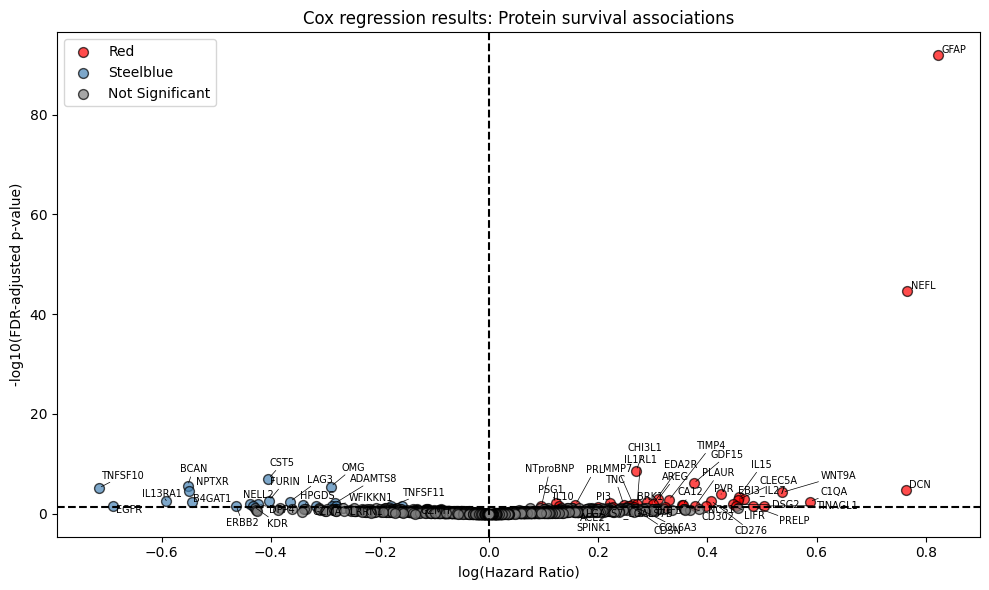

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Compute -log10(FDR) if not already done
protein_results_df['neg_log10_fdr'] = -np.log10(protein_results_df['p_fdr'])
protein_results_df['logHR'] = protein_results_df['coef']  # use logHR from coef

# Assign significance colors
def color_sign(row):
    if row['significant_fdr05']:
        return 'red' if row['logHR'] > 0 else 'steelblue'
    else:
        return 'grey'

protein_results_df['color'] = protein_results_df.apply(color_sign, axis=1)

# Plot
plt.figure(figsize=(10, 6))

for color in ['red', 'steelblue', 'grey']:
    subset = protein_results_df[protein_results_df['color'] == color]
    plt.scatter(
        subset['logHR'],
        subset['neg_log10_fdr'],
        label=color.capitalize() if color != 'grey' else 'Not Significant',
        color=color,
        alpha=0.7,
        edgecolors='k',
        s=50
    )

# Reference lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

# Annotate significant proteins
texts = []
sig_prots = protein_results_df[protein_results_df['significant_fdr05'] == True]

for _, row in sig_prots.iterrows():
    texts.append(
        plt.text(row['logHR'], row['neg_log10_fdr'], row['Protein_tested'], fontsize=7)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Labels and style
plt.xlabel("log(Hazard Ratio)")
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.legend()
plt.title("Cox regression results: Protein survival associations")
plt.tight_layout()
plt.show()


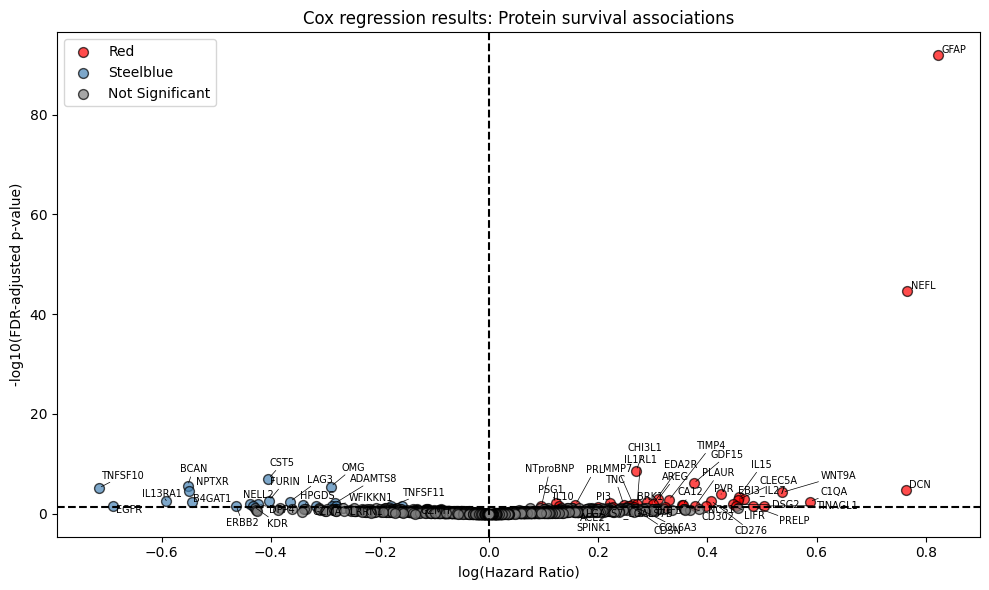

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Compute -log10(FDR) if not already done
protein_results_df['neg_log10_fdr'] = -np.log10(protein_results_df['p_fdr'])
protein_results_df['logHR'] = protein_results_df['coef']  # use logHR from coef

# Assign significance colors
def color_sign(row):
    if row['significant_fdr05']:
        return 'red' if row['logHR'] > 0 else 'steelblue'
    else:
        return 'grey'

protein_results_df['color'] = protein_results_df.apply(color_sign, axis=1)

# Plot
plt.figure(figsize=(10, 6))

for color in ['red', 'steelblue', 'grey']:
    subset = protein_results_df[protein_results_df['color'] == color]
    plt.scatter(
        subset['logHR'],
        subset['neg_log10_fdr'],
        label=color.capitalize() if color != 'grey' else 'Not Significant',
        color=color,
        alpha=0.7,
        edgecolors='k',
        s=50
    )

# Reference lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

# Annotate significant proteins
texts = []
sig_prots = protein_results_df[protein_results_df['significant_fdr05'] == True]

for _, row in sig_prots.iterrows():
    texts.append(
        plt.text(row['logHR'], row['neg_log10_fdr'], row['Protein_tested'], fontsize=7)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Labels and style
plt.xlabel("log(Hazard Ratio)")
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.legend()
plt.title("Cox regression results: Protein survival associations")
plt.tight_layout()
plt.show()


In [88]:
protein_results_df.to_csv("Cox_neuro.csv")

In [89]:
protein_results_df = protein_results_df[["Protein_tested", "coef", "exp(coef)", 
                                         "se(coef)", "coef lower 95%", "coef upper 95%", "p"]]


# Check which proteins have the same directionality in other neurodegenerative diseases 

In [90]:
df = pd.read_csv("Cox_neuro.csv")

In [91]:
df_pd = pd.read_csv("PDcox.csv")

In [92]:
# Sets of significant proteins
sig_df = set(df[df["p_fdr"] < 0.05]["Protein_tested"].unique())
sig_df_pd = set(df_pd[df_pd["p_fdr"] < 0.05]["Protein_tested"].unique())


In [93]:
# Filter df to keep only rows where Protein_tested is in sig_df
df_filtered = df[df["Protein_tested"].isin(sig_df)]

# Build dictionary: protein -> coef
sig_df_dictionary = dict(zip(df_filtered["Protein_tested"], df_filtered["coef"]))



In [94]:
df_filtered_pd = df_pd[df_pd["Protein_tested"].isin(sig_df_pd)]

# Build dictionary: protein -> coef
sig_df_dictionary_pd = dict(zip(df_filtered_pd["Protein_tested"], df_filtered_pd["coef"]))



In [95]:
# Filter significant proteins and build dictionaries
sig_df_dictionary = dict(
    zip(df[df["p_fdr"] < 0.05]["Protein_tested"], df[df["p_fdr"] < 0.05]["coef"])
)

sig_df_dictionary_pd = dict(
    zip(df_pd[df_pd["p_fdr"] < 0.05]["Protein_tested"], df_pd[df_pd["p_fdr"] < 0.05]["coef"])
)

# Find overlapping proteins
overlap_proteins = set(sig_df_dictionary.keys()).intersection(sig_df_dictionary_pd.keys())

# Check directionality
direction_comparison = []
for protein in overlap_proteins:
    coef_df = sig_df_dictionary[protein]
    coef_pd = sig_df_dictionary_pd[protein]
    direction_same = np.sign(coef_df) == np.sign(coef_pd)
    
    direction_comparison.append({
        "Protein": protein,
        "coef_df": coef_df,
        "coef_pd": coef_pd,
        "same_direction": direction_same
    })

# Convert to DataFrame
direction_df = pd.DataFrame(direction_comparison)

# Quick summary
print(direction_df.head())
print(f"Number of overlapping proteins: {len(overlap_proteins)}")
print(f"Number with same direction: {direction_df['same_direction'].sum()}")


   Protein   coef_df   coef_pd  same_direction
0    CD276  0.406524  0.415667            True
1    FURIN -0.403116 -0.529459            True
2  TNFSF10 -0.714952 -0.570739            True
3  IL13RA1 -0.591438 -0.701792            True
4     NEFL  0.765899  0.475896            True
Number of overlapping proteins: 7
Number with same direction: 7


In [96]:
proteins_all = df_filtered_pd[df_filtered_pd["p_fdr"] <0.05]["Protein_tested"].unique().tolist()

In [97]:
proteins_different = set(proteins_all) - set(direction_df["Protein"].unique().tolist())

In [98]:
# Write to a file
with open("proteins_cox_specificPD_list.txt", "w") as f:
    for protein in proteins_different:
        f.write(protein + "\n")